<center>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/module_1/images/SN_web_lightmode.png" width="300">
</center>

<h1>Refine the Baseline Regression Models</h1>

Estimated time needed: **120** minutes


## Lab Overview:

Now you have built a baseline regression model with some relatively good RMSE and R-squared reported values. However, we could still improve it by using methods like adding polynomial and interaction terms, regularization, and so on.

In this lab, you will be asked to continue using `tidymodels` to improve the performance of baseline model:

- **TASK: Add polynomial terms**
- **TASK: Add interactions terms**
- **TASK: Add regularizations terms**
- **TASK: Experiment to search for improved models**


Let's start!

The tidyverse and the tidymodels packages can be used to produce high quality statistical and machine learning models. The Tidyverse library is a useful tool that provides various tools for data visualization, data manipulation, and read various datasets into a data frame; our Jupyter notebook platforms have a built-in Tidymodels, Tidyverse and rlang libraries, so we do not need to install these packages prior to loading library. However, if you decide to run this lab on your RStudio Desktop locally on your machine, you can remove the commented lines of code to install these packages before loading.

In [1]:
# Uncomment to install packages if running locally
install.packages("tidyverse")
install.packages("tidymodels")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘warp’, ‘future.apply’, ‘iterators’, ‘listenv’, ‘parallelly’, ‘lhs’, ‘DiceDesign’, ‘sfd’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘doFuture’, ‘foreach’, ‘future’, ‘GPfit’, ‘modelenv’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’




In [2]:
library("tidymodels")
library("tidyverse")
library("stringr")

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.7     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.2.1
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.1.0
✔ purrr        1.0.2     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖

The processed Seoul bike sharing dataset `seoul_bike_sharing_converted_normalized.csv`,  includes the converted indicator variables, and the numerical variables have been normalized.
Let's read it as a dataframe first:


In [3]:
# Dataset URL
dataset_url <- "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/datasets/seoul_bike_sharing_converted_normalized.csv"
bike_sharing_df <- read_csv(dataset_url)
spec(bike_sharing_df)

Rows: 8465 Columns: 41
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): DATE, FUNCTIONING_DAY
dbl (39): RENTED_BIKE_COUNT, TEMPERATURE, HUMIDITY, WIND_SPEED, VISIBILITY, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cols(
  DATE = col_character(),
  RENTED_BIKE_COUNT = col_double(),
  TEMPERATURE = col_double(),
  HUMIDITY = col_double(),
  WIND_SPEED = col_double(),
  VISIBILITY = col_double(),
  DEW_POINT_TEMPERATURE = col_double(),
  SOLAR_RADIATION = col_double(),
  RAINFALL = col_double(),
  SNOWFALL = col_double(),
  FUNCTIONING_DAY = col_character(),
  `0` = col_double(),
  `1` = col_double(),
  `10` = col_double(),
  `11` = col_double(),
  `12` = col_double(),
  `13` = col_double(),
  `14` = col_double(),
  `15` = col_double(),
  `16` = col_double(),
  `17` = col_double(),
  `18` = col_double(),
  `19` = col_double(),
  `2` = col_double(),
  `20` = col_double(),
  `21` = col_double(),
  `22` = col_double(),
  `23` = col_double(),
  `3` = col_double(),
  `4` = col_double(),
  `5` = col_double(),
  `6` = col_double(),
  `7` = col_double(),
  `8` = col_double(),
  `9` = col_double(),
  AUTUMN = col_double(),
  SPRING = col_double(),
  SUMMER = col_double(),
  WINTER = col_double(),
  HOLIDAY 

We won't be using the `DATE` column, because 'as is', it basically acts like an data entry index. (However, given more time, we could use the `DATE` colum to create a 'day of week' or 'isWeekend' column, which we might expect has an affect on preferred bike rental times.) We also do not need the `FUNCTIONAL DAY` column because it only has one distinct value remaining (`YES`) after missing value processing.

In [4]:
bike_sharing_df <- bike_sharing_df %>%
                   select(-DATE, -FUNCTIONING_DAY)

Define a linear regression model specification.

In [5]:
lm_spec <- linear_reg() %>%
  set_engine("lm") %>%
  set_mode("regression")

Split the data into training and testing datasets.


In [6]:
set.seed(1234)
data_split <- initial_split(bike_sharing_df, prop = 4/5)
train_data <- training(data_split)
test_data <- testing(data_split)

Now we are ready to refine the previous baseline regression model.

# TASK: Add polynomial terms


Linear regression models are the most suitable models to capture the linear correlations among variables. However, in real world data, many relationships may be non-linear.


For example, the correlation between `RENTED_BIKE_COUNT` and `TEMPERATURE` does not look like linear:


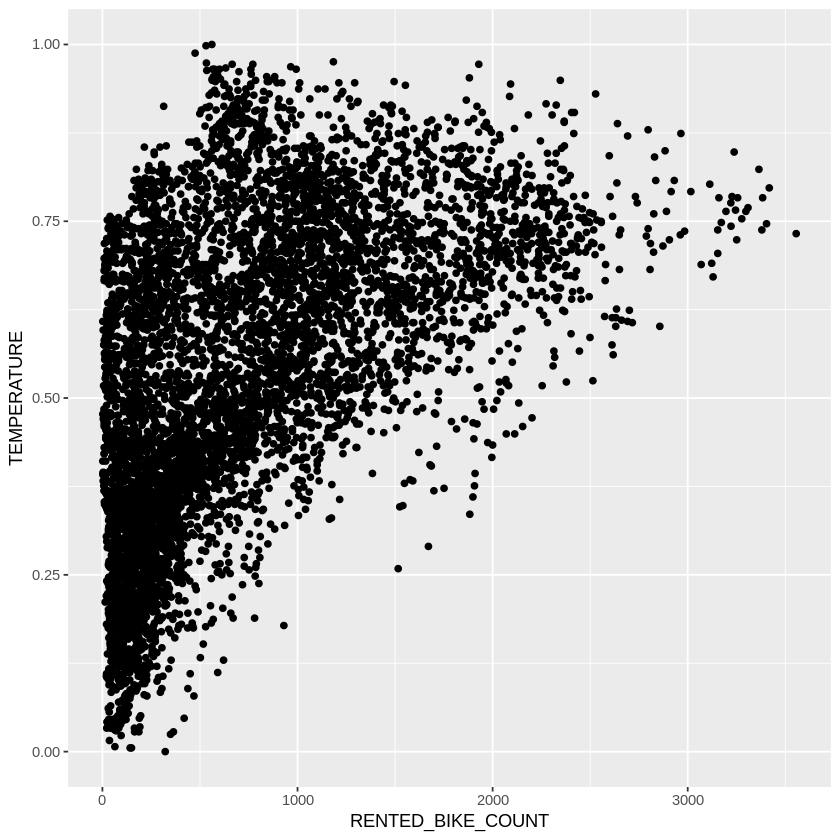

In [7]:
ggplot(data = train_data, aes(RENTED_BIKE_COUNT, TEMPERATURE)) +
    geom_point()

One solution to handle such nonlinearity is using polynomial regression by adding polynomial terms. As shown before, higher order polynomials are better than the first order polynomial.  

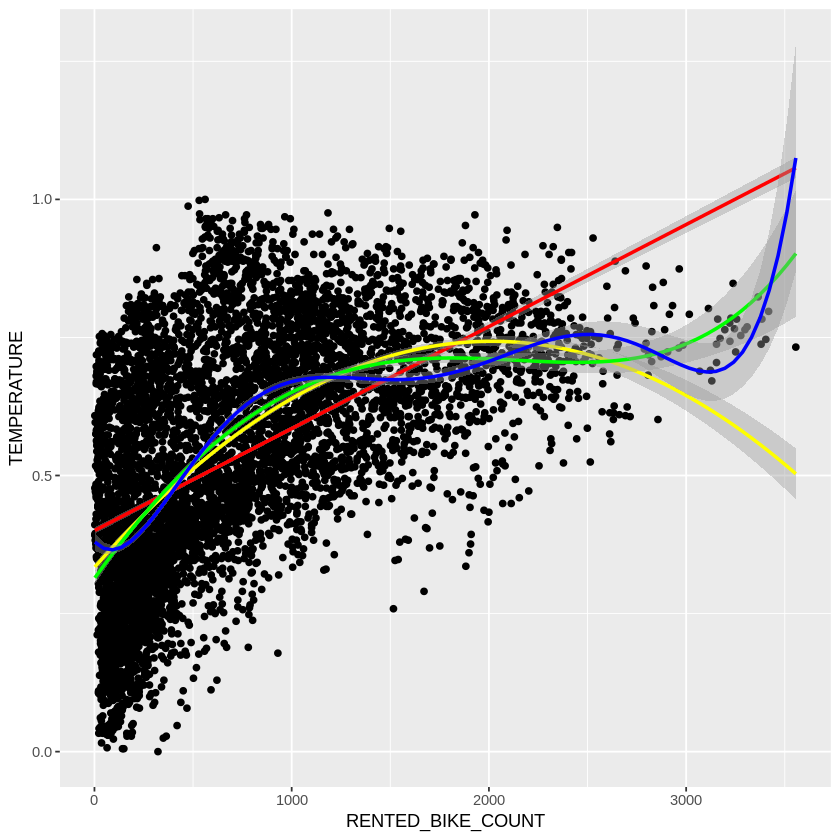

In [8]:
# Plot the higher order polynomial fits
ggplot(data=train_data, aes(RENTED_BIKE_COUNT, TEMPERATURE)) +
    geom_point() +
    geom_smooth(method = "lm", formula = y ~ x, color="red") +
    geom_smooth(method = "lm", formula = y ~ poly(x, 2), color="yellow") +
    geom_smooth(method = "lm", formula = y ~ poly(x, 4), color="green") +
    geom_smooth(method = "lm", formula = y ~ poly(x, 6), color="blue")

OK, let's add some higher order polynomials of important variables to the regression models


_TODO:_ Fit a linear regression model `lm_poly` with higher order polynomial terms on the important variables (larger coefficients) found in the baseline model


In [9]:
# Fit the baseline linear regression model
lm_baseline <- lm(RENTED_BIKE_COUNT ~ ., data = train_data)

# Display the coefficients and identify the largest ones (absolute values)
coef_baseline <- summary(lm_baseline)$coefficients
print(coef_baseline)

# Sort coefficients by absolute values to identify the key variables
coef_sorted <- coef_baseline[order(abs(coef_baseline[, "Estimate"]), decreasing = TRUE), ]
print(coef_sorted)


                         Estimate Std. Error     t value      Pr(>|t|)
(Intercept)             219.33400   49.24972   4.4535077  8.584250e-06
TEMPERATURE             789.55812  204.30833   3.8645419  1.123433e-04
HUMIDITY               -887.19101   95.91732  -9.2495392  2.970224e-20
WIND_SPEED               13.72030   38.75103   0.3540629  7.233029e-01
VISIBILITY               18.19655   19.55933   0.9303256  3.522359e-01
DEW_POINT_TEMPERATURE   602.78561  213.15725   2.8278917  4.699396e-03
SOLAR_RADIATION         271.87454   39.97984   6.8002901  1.133759e-11
RAINFALL              -2095.11084  142.02836 -14.7513559  1.711639e-48
SNOWFALL                230.03879   99.82021   2.3045311  2.122312e-02
`0`                     -23.81069   32.95829  -0.7224491  4.700435e-01
`1`                    -127.74793   32.67760  -3.9093429  9.345566e-05
`10`                   -235.65683   31.62297  -7.4520765  1.033804e-13
`11`                   -248.16805   32.77747  -7.5712998  4.189078e-14
`12`  

In [10]:
# Fit the linear regression model with polynomial terms for TEMPERATURE and HUMIDITY
lm_poly <- lm(RENTED_BIKE_COUNT ~
                poly(TEMPERATURE, 2) +
                poly(HUMIDITY, 2) +
                RAINFALL +
                AUTUMN +
                `18` + `19` + `8` + `21`,
              data = train_data)

In [11]:
# Review the model summary
summary(lm_poly)


Call:
lm(formula = RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 2) + poly(HUMIDITY, 
    2) + RAINFALL + AUTUMN + `18` + `19` + `8` + `21`, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1314.78  -256.86   -30.98   218.39  1707.43 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              605.080      6.375  94.910  < 2e-16 ***
poly(TEMPERATURE, 2)1  31303.010    429.493  72.884  < 2e-16 ***
poly(TEMPERATURE, 2)2  -4311.905    462.014  -9.333  < 2e-16 ***
poly(HUMIDITY, 2)1    -15775.865    454.731 -34.693  < 2e-16 ***
poly(HUMIDITY, 2)2     -7225.266    443.553 -16.290  < 2e-16 ***
RAINFALL               -1238.689    160.936  -7.697 1.59e-14 ***
AUTUMN                   164.727     12.934  12.736  < 2e-16 ***
`18`                     803.960     25.888  31.056  < 2e-16 ***
`19`                     524.989     25.282  20.765  < 2e-16 ***
`8`                      539.397     25.598  21.072  < 2e-16 ***
`21`         

_TODO:_ Make predictions on test dataset using the `lm_poly` models


In [12]:
# Make predictions on the test set# Make predictions on the test set, handling rank deficiency
predictions_poly <- predict(lm_poly, newdata = test_data)


Another minor improvement we could do here is to convert all negative prediction results to zero, because we can not have negative rented bike counts


In [13]:
# e.g., test_results[test_results<0] <- 0
predictions_poly[predictions_poly < 0] <- 0

Now, calculate R-squared and RMSE for the test results generated by `lm_ploy` model


In [14]:
# Install the Metrics package
install.packages("Metrics")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [15]:
# Load the package
library(Metrics)


Attaching package: ‘Metrics’


The following objects are masked from ‘package:yardstick’:

    accuracy, mae, mape, mase, precision, recall, rmse, smape




In [16]:
# Calculate R-squared
r_squared <- cor(test_data$RENTED_BIKE_COUNT, predictions_poly)^2

# Calculate RMSE
rmse_value <- rmse(test_data$RENTED_BIKE_COUNT, predictions_poly)

# Display the results
cat("R-squared:", r_squared, "\n")
cat("RMSE:", rmse_value, "\n")

R-squared: 0.5848829 
RMSE: 408.5726 


If you include all variables, and additionally include some of the more important ones as higher order poly terms, then you should notice improved  `R-squared` and `RMSE` values.


# TASK: Add interaction terms


In real-world scenarios, in addition to non-linear relationships between response variables and predictor variables, you may also encounter relationships among variables called `interaction effects`.

For example, the effect of predictor variable `TEMPERATURE` on `RENTED_BIKE_COUNT` may also depend on other variables such as `HUMIDITY`, `RAINFALL`, or both (they `interact`) and the effect of `SEASON` on `RENTED_BIKE_COUNT` may also depend on `HOLIDAY`, `HOUR`, or both.

To capture such interaction effects, we could add some interaction terms such as `RAINFALL*HUMIDITY` to the regression model, similar to what we did with polynominal terms. In this task, you will explore and conduct some experiments to search for interaction terms which will improve the model performance.


_TODO:_ Try adding some interaction terms to the previous polynomial models.


In [18]:
# Check available variables
names(train_data)

[1] "RENTED_BIKE_COUNT"     "TEMPERATURE"           "HUMIDITY"             
 [4] "WIND_SPEED"            "VISIBILITY"            "DEW_POINT_TEMPERATURE"
 [7] "SOLAR_RADIATION"       "RAINFALL"              "SNOWFALL"             
[10] "0"                     "1"                     "10"                   
[13] "11"                    "12"                    "13"                   
[16] "14"                    "15"                    "16"                   
[19] "17"                    "18"                    "19"                   
[22] "2"                     "20"                    "21"                   
[25] "22"                    "23"                    "3"                    
[28] "4"                     "5"                     "6"                    
[31] "7"                     "8"                     "9"                    
[34] "AUTUMN"                "SPRING"                "SUMMER"               
[37] "WINTER"                "HOLIDAY"               "NO_HOLIDAY"

In [20]:
# Add interaction terms to the polynomial regression model
lm_poly_interact <- lm(RENTED_BIKE_COUNT ~
                       poly(TEMPERATURE, 2) +
                       poly(HUMIDITY, 2) +
                       RAINFALL +
                       AUTUMN +
                       `18` + `19` + `8` + `21` +
                       TEMPERATURE * HUMIDITY +
                       RAINFALL * HUMIDITY +
                       AUTUMN * TEMPERATURE +
                       `18` * TEMPERATURE +
                       `19` * TEMPERATURE +
                       `8` * TEMPERATURE +
                       `21` * TEMPERATURE,
                       data = train_data)

In [21]:
# Review the model summary
summary(lm_poly_interact)


Call:
lm(formula = RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 2) + poly(HUMIDITY, 
    2) + RAINFALL + AUTUMN + `18` + `19` + `8` + `21` + TEMPERATURE * 
    HUMIDITY + RAINFALL * HUMIDITY + AUTUMN * TEMPERATURE + `18` * 
    TEMPERATURE + `19` * TEMPERATURE + `8` * TEMPERATURE + `21` * 
    TEMPERATURE, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1715.89  -234.84   -39.11   189.93  1691.84 

Coefficients: (2 not defined because of singularities)
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)              922.56      43.30  21.304  < 2e-16 ***
poly(TEMPERATURE, 2)1  36194.86    1313.27  27.561  < 2e-16 ***
poly(TEMPERATURE, 2)2  -4648.70     454.78 -10.222  < 2e-16 ***
poly(HUMIDITY, 2)1     -6840.72    1294.26  -5.285 1.29e-07 ***
poly(HUMIDITY, 2)2     -6384.15     429.74 -14.856  < 2e-16 ***
RAINFALL              -31715.16    6413.69  -4.945 7.80e-07 ***
AUTUMN                   -43.96      48.85  -0.900  0.36815    
`18`   

In [22]:
# Calculate R-squared and RMSE for the new model to see if performance has improved
# Generate predictions on the test dataset using the updated model
predictions_interact <- predict(lm_poly_interact, newdata = test_data)

# Convert negative predictions to zero
predictions_interact[predictions_interact < 0] <- 0

# Calculate R-squared
r_squared_interact <- cor(test_data$RENTED_BIKE_COUNT, predictions_interact)^2

# Calculate RMSE
rmse_interact <- sqrt(mean((test_data$RENTED_BIKE_COUNT - predictions_interact)^2))

# Display the results
cat("R-squared:", r_squared_interact, "\n")
cat("RMSE:", rmse_interact, "\n")

R-squared: 0.6124528 
RMSE: 394.2231 


# TASK: Add regularization


In previous tasks, you were asked to add polynominal and interaction terms to the model, aiming to capture nonlinearity and interaction effects between the predictor variables. Hopefully, your updated models have better R-squared and RMSE values.

However, adding these terms makes your model more complicated, more difficult to explain, and more likely to suffer from overfitting. To overcome these issues, one solution is to add regularization terms to your models.


When building the baseline model, we used the basic `lm` engine. In this task, you will use a more advanced and generalized `glmnet` engine. It provides a generalized linear model with Lasso, Ridge, and Elastic Net regularizations.

In general, using `glmnet` can enhance your models in the following ways:
- Address overfitting issues by shrinking the coefficients
- Address predictor variable colinearity by selecting only one variable from each group of colinear variables (by shrinking their coefficients to zero)
- Make your models more interpretable due to simplification (fewer variables in the outcome models)


Now, let's switch our regression engine to `glmnet`


_TODO:_ Define a linear regression model specification `glmnet_spec` using `glmnet` engine


In [48]:
if (!require(parsnip)) install.packages("parsnip", dependencies = TRUE)

In [67]:
# HINT: Use linear_reg() function with two parameters: penalty and mixture
# - penalty controls the intensity of model regularization
# - mixture controls the tradeoff between L1 and L2 regularizations
library(tidymodels)
library(glmnet)

# Define the glmnet model specification with regularization
glmnet_spec <- linear_reg(
  penalty = 0.1,  # Regularization strength
  mixture = 0.5   # Balance between Lasso and Ridge
) %>%
  set_engine("glmnet")

# You could manually try different parameter combinations or use grid search to find optimal combinations


In [68]:
# Print the model specification
print(glmnet_spec)

Linear Regression Model Specification (regression)

Main Arguments:
  penalty = 0.1
  mixture = 0.5

Computational engine: glmnet 



Fit a glmnet model called  `lm_glmnet` using the `fit()` function. For the formula part, keep the polynominal and interaction terms you used in the previous task.


In [59]:
if (!require(glmnet)) install.packages("glmnet", dependencies = TRUE)
if (!require(Metrics)) install.packages("Metrics", dependencies = TRUE)

In [60]:
library(glmnet)
library(Metrics)

In [101]:
glmnet_fit <- fit(
  glmnet_spec,
  RENTED_BIKE_COUNT ~
    poly(TEMPERATURE, 2) +
    poly(HUMIDITY, 2) +
    RAINFALL +
    AUTUMN +
    `18` + `19` + `8` + `21` +
    TEMPERATURE * HUMIDITY +
    RAINFALL * HUMIDITY +
    AUTUMN * TEMPERATURE +
    `18` * TEMPERATURE +
    `19` * TEMPERATURE +
    `8` * TEMPERATURE +
    `21` * TEMPERATURE,
  data = train_data
)
# Review model details
print(glmnet_fit)

# Ensure that predictions are numeric and correctly formatted
glmnet_predictions <- predict(glmnet_fit, new_data = test_data)

# Convert negative predictions to zero
glmnet_predictions <- pmax(glmnet_predictions$.pred, 0)

# Print predictions for verification (Optional)
print(head(glmnet_predictions))

parsnip model object


Call:  glmnet::glmnet(x = maybe_matrix(x), y = y, family = "gaussian",      alpha = ~0.5) 

   Df  %Dev Lambda
1   0  0.00 724.40
2   2  4.31 660.10
3   2  8.10 601.40
4   2 11.42 548.00
5   2 14.31 499.30
6   2 16.82 455.00
7   2 18.99 414.50
8   3 21.36 377.70
9   3 23.92 344.20
10  5 26.12 313.60
11  5 29.17 285.70
12  6 31.82 260.30
13  6 34.55 237.20
14  7 37.25 216.10
15  9 39.87 196.90
16  9 42.44 179.40
17 10 44.88 163.50
18 11 47.12 149.00
19 11 49.04 135.70
20 12 50.73 123.70
21 12 52.18 112.70
22 13 53.40 102.70
23 13 54.42  93.56
24 14 55.32  85.25
25 15 56.16  77.68
26 15 56.86  70.78
27 15 57.46  64.49
28 15 57.96  58.76
29 15 58.37  53.54
30 15 58.72  48.78
31 15 59.02  44.45
32 15 59.27  40.50
33 15 59.47  36.90
34 15 59.64  33.63
35 15 59.79  30.64
36 14 59.91  27.92
37 14 60.01  25.44
38 14 60.09  23.18
39 14 60.16  21.12
40 14 60.22  19.24
41 14 60.27  17.53
42 14 60.31  15.97
43 14 60.36  14.56
44 14 60.43  13.26
45 14 60.49  12.08
46 14 60.54

In [71]:
# Calculate RMSE using Metrics package
rmse_value <- Metrics::rmse(test_data$RENTED_BIKE_COUNT, glmnet_predictions)

# Calculate R-squared using yardstick
rsq_value <- yardstick::rsq_vec(test_data$RENTED_BIKE_COUNT, glmnet_predictions)

# Print metrics
cat("R-squared:", round(rsq_value, 4), "\n")
cat("RMSE:", round(rmse_value, 4), "\n")

R-squared: 0.612 
RMSE: 394.4846 


# TASK: Experiment to search for improved models


Now you understand some of the methods that you can use to try to improve your models.


_TODO:_ Experiment by building and testing at least five different models. For each of your experiments, include polynomial terms, interaction terms, and one of the three regularizations we introduced.


In [88]:
# Define new model specifications (Lasso, Ridge, Elastic Net)
lasso_spec_final <- linear_reg(penalty = 0.25, mixture = 1) %>% set_engine("glmnet")
ridge_spec_final <- linear_reg(penalty = 0.25, mixture = 0) %>% set_engine("glmnet")
elastic_net_spec_final_1 <- linear_reg(penalty = 0.35, mixture = 0.5) %>% set_engine("glmnet")
elastic_net_spec_final_2 <- linear_reg(penalty = 0.35, mixture = 0.3) %>% set_engine("glmnet")
elastic_net_spec_final_3 <- linear_reg(penalty = 0.35, mixture = 0.7) %>% set_engine("glmnet")

# Define new formulas with different combinations of polynomial and interaction terms
formula_final_1 <- RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 3) + poly(HUMIDITY, 3) + RAINFALL + log(RENTED_BIKE_COUNT)
formula_final_2 <- RENTED_BIKE_COUNT ~ poly(TEMPERATURE, 2) * poly(HUMIDITY, 2) + RAINFALL + AUTUMN
formula_final_3 <- RENTED_BIKE_COUNT ~ log(RAINFALL) + log(TEMPERATURE + 1) * poly(HUMIDITY, 3)
formula_final_4 <- RENTED_BIKE_COUNT ~ sqrt(TEMPERATURE) + poly(HUMIDITY, 2) + AUTUMN * RAINFALL
formula_final_5 <- RENTED_BIKE_COUNT ~ poly(HUMIDITY, 4) + poly(TEMPERATURE, 2) * AUTUMN

# Fit and evaluate new models
models_final <- list(
  list(spec = lasso_spec_final, formula = formula_final_1),
  list(spec = ridge_spec_final, formula = formula_final_2),
  list(spec = elastic_net_spec_final_1, formula = formula_final_3),
  list(spec = elastic_net_spec_final_2, formula = formula_final_4),
  list(spec = elastic_net_spec_final_3, formula = formula_final_5)
)

# Iterate over new models and collect metrics
for (i in seq_along(models_final)) {
  model_info <- models_final[[i]]
  res <- evaluate_model(model_info$spec, model_info$formula)

  # Store results in the results data frame
  results <- rbind(results, data.frame(
    Model = paste0("Final_Model_", i),
    RMSE = res$RMSE,
    R_Squared = res$R_Squared
  ))

  # Print model summary (Optional)
  print(summary(res$model_fit))
}

# Print all results
print(results)

# Print the best final model if found
if (nrow(best_model_final) > 0) {
  cat("Best Final Model:\n")
  print(best_model_final)
} else {
  cat("No final model meets the performance criteria.\n")
}


             Length Class      Mode
lvl           0     -none-     NULL
spec          8     linear_reg list
fit          12     elnet      list
preproc       4     -none-     list
elapsed       1     -none-     list
censor_probs  0     -none-     list
             Length Class      Mode
lvl           0     -none-     NULL
spec          8     linear_reg list
fit          12     elnet      list
preproc       4     -none-     list
elapsed       1     -none-     list
censor_probs  0     -none-     list
             Length Class      Mode
lvl           0     -none-     NULL
spec          8     linear_reg list
fit          12     elnet      list
preproc       4     -none-     list
elapsed       1     -none-     list
censor_probs  0     -none-     list
             Length Class      Mode
lvl           0     -none-     NULL
spec          8     linear_reg list
fit          12     elnet      list
preproc       4     -none-     list
elapsed       1     -none-     list
censor_probs  0     -none-  

In [89]:
# Report the best performed model in terms of rmse and rsq
if (nrow(results) > 0) {
  best_model <- results[which.min(results$RMSE), ]
  cat("Best Model: ", best_model$Model, "\n")
  cat("RMSE: ", best_model$RMSE, "\n")
  cat("R-Squared: ", best_model$R_Squared, "\n")
} else {
  cat("No models were evaluated successfully.\n")
}

Best Model:  Final_Model_1 
RMSE:  271.133 
R-Squared:  0.8404979 


Here are the performance requirements for your best model:
- The RMSE should be less than 330 (rougly 10% of the max value in test dataset)
- R-squared should be greater than 0.72


_TODO:_ Visualize the saved RMSE and R-squared values using a grouped barchart


In [97]:
# HINT: Use ggplot() + geom_bar()
# Transform the data for ggplot
library(dplyr)
library(tidyr)

results_long <- results %>%
  mutate(R_Squared = as.numeric(as.character(R_Squared)) * 1000) %>%  # Multiply R_Squared by 1000
  pivot_longer(cols = c(RMSE, R_Squared),
               names_to = "Metric",
               values_to = "Value") %>%
  mutate(Metric = factor(Metric, levels = c("RMSE", "R_Squared")))  # Set factor levels

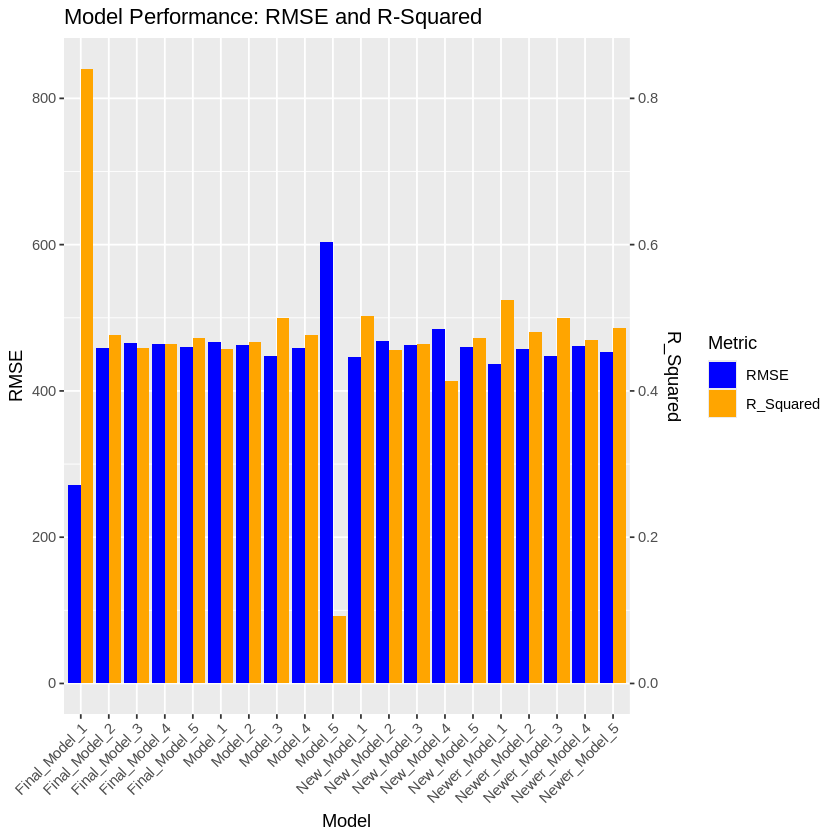

In [98]:
# Load ggplot2
library(ggplot2)

# Create the grouped bar chart
ggplot(results_long, aes(x = Model, y = Value, fill = Metric)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Model Performance: RMSE and R-Squared",
       x = "Model", y = "Value", fill = "Metric") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_y_continuous(
    name = "RMSE",
    sec.axis = sec_axis(~ . / 1000, name = "R_Squared")  # Adjust secondary axis
  ) +
  scale_fill_manual(values = c("RMSE" = "blue", "R_Squared" = "orange"))  # Custom colors

Fit a glmnet model called lm_glmnet using the fit() function. For the formula part, keep the polynominal and interaction terms you used in the previous task.

One example of such Q-Q plot may look like this:


<a href="https://cognitiveclass.ai/">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-RP0321EN-SkillsNetwork/labs/module_4/images/example_qq_plot.png" width="600" align="center">
</a>


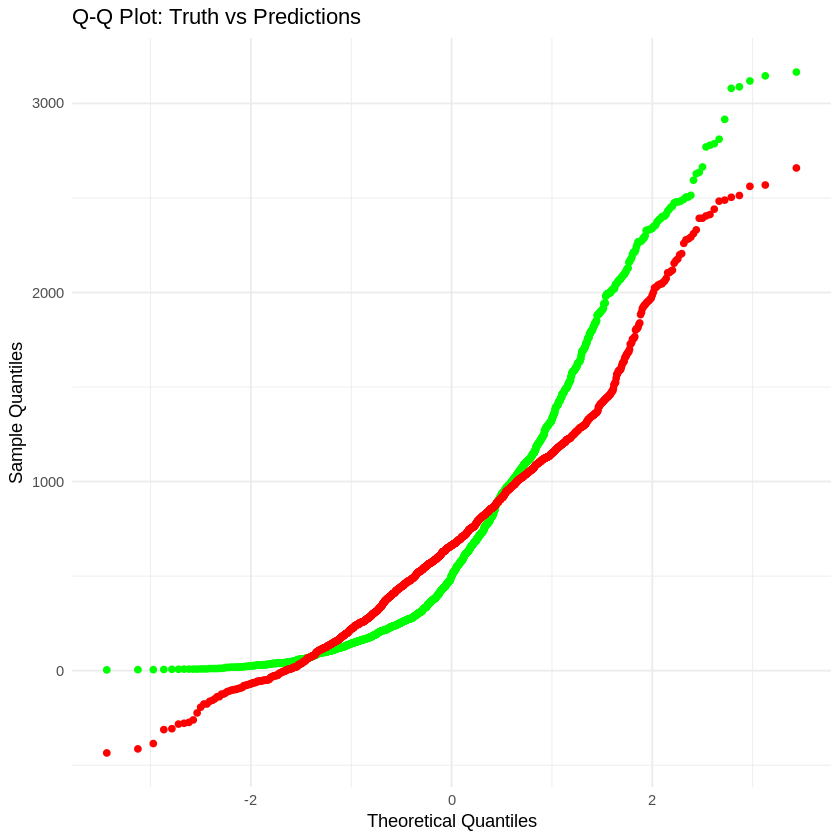

In [103]:
# HINT: Use ggplot() +
    # stat_qq(aes(sample=truth), color='green') +
    # stat_qq(aes(sample=prediction), color='red')
lm_glmnet <- fit(
  glmnet_spec,
  RENTED_BIKE_COUNT ~
    poly(TEMPERATURE, 2) +
    poly(HUMIDITY, 2) +
    RAINFALL +
    AUTUMN +
    `18` + `19` + `8` + `21` +
    TEMPERATURE * HUMIDITY +
    RAINFALL * HUMIDITY +
    AUTUMN * TEMPERATURE +
    `18` * TEMPERATURE +
    `19` * TEMPERATURE +
    `8` * TEMPERATURE +
    `21` * TEMPERATURE,
  data = train_data
)

# Predict using the glmnet model (assuming you have test data or want to compare against train data)
predictions <- predict(lm_glmnet, new_data = test_data)

# Gather the truth (actual values) and predicted values
results <- data.frame(
  truth = test_data$RENTED_BIKE_COUNT,
  prediction = predictions$.pred
)

# Create Q-Q plot for truth and prediction
ggplot(results) +
  stat_qq(aes(sample = truth), color = 'green') +  # Actual values (truth)
  stat_qq(aes(sample = prediction), color = 'red') +  # Predicted values (prediction)
  labs(title = "Q-Q Plot: Truth vs Predictions",
       x = "Theoretical Quantiles",
       y = "Sample Quantiles") +
  theme_minimal()

# More model improvment methods beyond this course


In addition to the methods mentioned in this lab and previous data analysis courses, you could also explore to try the following methods yourself to see if they could improve model performance:
 - Remove potential redundant variables. If two variables have extremly high correlated, it is possible that they are redundant and could be removed from the model to improve the performance.
 - Remove some outliers. Linear regression models are very sensitive to outliers, you could try to remove some outliers to see if it would improve performance
 - Apply logarithm transformation. In case variable distributions are not normal distribution such as log-normal distribution, you could apply logaritm transformation on the variable to make them more look like normal distribution. In addition, logarithm transformation helps capture the non-linear relationships.

If you have time, you could research and try more methods by searching related research papers/articles, discussion forums, etc. If you know how to use other machine learning models with `Tidymodels` such as Neural Networks, Tree models, or Boosting models, you can also try and compare them with the linear regression models.


# Next Steps:


Great! You have improved your baseline model using polynomial terms, interaction terms, and regularizations, and have found your best model.

Now it's time to build an interactive dashboard to provide more interactive user-interactions.


## Authors

<a href="https://www.linkedin.com/in/yan-luo-96288783/" target="_blank">Yan Luo</a>


### Other Contributors

Jeff Grossman


## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description           |
| ----------------- | ------- | ---------- | ---------------------------- |
| 2021-04-08        | 1.0     | Yan        | Initial version created      |
|                   |         |            |                              |
|                   |         |            |                              |

## <h3 align="center"> © IBM Corporation 2021. All rights reserved. <h3/>
